In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:

# Input path
input_root = "/content/drive/MyDrive/Project/images"

# Output path for resized images
output_root = "/content/drive/MyDrive/Project/resized_images_256"
os.makedirs(output_root, exist_ok=True)


In [ ]:
from PIL import Image
from tqdm import tqdm

def resize_images_pil(input_dir, output_dir, size=(256, 256)):
    for root, dirs, files in os.walk(input_dir):
        relative_path = os.path.relpath(root, input_dir)
        new_folder_path = os.path.join(output_dir, relative_path)
        os.makedirs(new_folder_path, exist_ok=True)

        for file in tqdm(files, desc=f"Processing {relative_path}", ncols=100):
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                input_path = os.path.join(root, file)
                output_path = os.path.join(new_folder_path, file)

                try:
                    img = Image.open(input_path).convert('RGB')
                    img = img.resize(size, Image.LANCZOS)
                    img.save(output_path)
                except Exception as e:
                    print(f"Failed to process {input_path}: {e}")

#both wet and dry folders
input_root = "/content/drive/MyDrive/Project/images"
output_root = "/content/drive/MyDrive/Project/resized_images_256"

resize_images_pil(os.path.join(input_root, "coral_images_wet"), os.path.join(output_root, "coral_images_wet"))
resize_images_pil(os.path.join(input_root, "coral_images_dry"), os.path.join(output_root, "coral_images_dry"))


In [4]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Load metadata files
ann = pd.read_csv('/content/drive/MyDrive/Project/meta_data.csv/annotations.csv')
labels = pd.read_csv('/content/drive/MyDrive/Project/meta_data.csv/labelsets.csv')

#Convert 'label' to string in both dataframes before merging
ann['label'] = ann['label'].astype(str)
labels['label'] = labels['label'].astype(str)

# Merge on 'label' to get readable 'label_name'
df = pd.merge(ann, labels, how='left', on='label')

# Keep only what we need
df = df[['patchid', 'label_name']].dropna()
df = df.rename(columns={'label_name': 'label'})

# Encode class labels
le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df['label'])
print("Number of unique classes:", df['label_encoded'].nunique())
df.head()


Number of unique classes: 9


,patchid,label,label_encoded
0,CBK_0001_00_20230804_0001_1,Background,0
1,CBK_0001_00_20230804_0001_2,Background,0
2,CBK_0001_00_20230804_0001_3,Background,0
3,CBK_0001_00_20230804_0001_4,Background,0
4,CBK_0001_00_20230804_0001_5,Background,0


In [5]:
from sklearn.model_selection import train_test_split

# Filter classes with only one image (stratification needs ≥2 per class)
class_counts = df['label_encoded'].value_counts()
valid_classes = class_counts[class_counts > 1].index
df_filtered = df[df['label_encoded'].isin(valid_classes)]

# Split: 80% train, 10% val, 10% test
train_df, test_df = train_test_split(df_filtered, test_size=0.2, stratify=df_filtered['label_encoded'], random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.1, stratify=train_df['label_encoded'], random_state=42)

print(f"Train size: {len(train_df)}")
print(f"Validation size: {len(val_df)}")
print(f"Test size: {len(test_df)}")


Train size: 6966
Validation size: 775
Test size: 1936


In [6]:
import os
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# Transform (skip resizing if already 256x256)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])


In [7]:
from torch.utils.data import Dataset
from PIL import Image
import os

class CoralDataset(Dataset):
    def __init__(self, df, root_dir, transform=None):
        self.transform = transform
        self.root_dir = root_dir

        # Cache all image paths
        self.image_paths = {}
        for folder in ["coral_images_dry", "coral_images_wet"]:
            folder_path = os.path.join(root_dir, folder)
            for root, _, files in os.walk(folder_path):
                for fname in files:
                    if fname.endswith(('.jpg', '.jpeg', '.png')):
                        self.image_paths[fname] = os.path.join(root, fname)

        # Filter out missing images from df
        df = df.copy()
        existing_files = set(self.image_paths.keys())
        valid_rows = df['patchid'].apply(lambda x: x + '.jpg' in existing_files)
        self.df = df[valid_rows].reset_index(drop=True)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = self.df.loc[idx, 'patchid'] + '.jpg'
        label = self.df.loc[idx, 'label_encoded']

        img_path = self.image_paths[img_name]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label


In [8]:
image_root = "/content/drive/MyDrive/Project/resized_images_256"

train_dataset = CoralDataset(train_df, image_root, transform=transform)
val_dataset = CoralDataset(val_df, image_root, transform=transform)
test_dataset = CoralDataset(test_df, image_root, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)


In [9]:
import torch.nn as nn
from torchvision import models

# Number of output classes
num_classes = df['label_encoded'].nunique()

# Load ResNet18
resnet18 = models.resnet18(pretrained=True)
resnet18.fc = nn.Linear(resnet18.fc.in_features, num_classes)

# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet18 = resnet18.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18.parameters(), lr=0.0003)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 127MB/s]


In [10]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        train_loss, train_correct, total = 0.0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            train_correct += (preds == labels).sum().item()
            train_loss += loss.item()

        train_acc = 100 * train_correct / total
        print(f"[Epoch {epoch+1}] Train Loss: {train_loss/len(train_loader):.4f}, Accuracy: {train_acc:.2f}%")

        # Validation
        model.eval()
        val_correct, val_total = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, preds = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (preds == labels).sum().item()

        val_acc = 100 * val_correct / val_total
        print(f"Validation Accuracy: {val_acc:.2f}%\n")
        scheduler.step()

    return model


In [ ]:
#SKIP RUNNING THIS
resnet18 = train_model(resnet18, criterion, optimizer, scheduler, num_epochs=10)



[Epoch 1] Train Loss: 0.9934, Accuracy: 65.21%
Validation Accuracy: 68.90%

[Epoch 2] Train Loss: 0.6938, Accuracy: 75.65%
Validation Accuracy: 68.13%

[Epoch 3] Train Loss: 0.5590, Accuracy: 80.20%
Validation Accuracy: 74.84%

[Epoch 4] Train Loss: 0.4360, Accuracy: 84.26%
Validation Accuracy: 73.68%

[Epoch 5] Train Loss: 0.3156, Accuracy: 88.49%
Validation Accuracy: 73.94%

[Epoch 6] Train Loss: 0.1156, Accuracy: 96.60%
Validation Accuracy: 81.03%

[Epoch 7] Train Loss: 0.0471, Accuracy: 98.68%
Validation Accuracy: 80.65%

[Epoch 8] Train Loss: 0.0338, Accuracy: 99.01%
Validation Accuracy: 76.52%

[Epoch 9] Train Loss: 0.0311, Accuracy: 99.14%
Validation Accuracy: 78.71%

[Epoch 10] Train Loss: 0.0313, Accuracy: 99.14%
Validation Accuracy: 78.97%



In [45]:
#SKIP RUNNING THIS
# Save to Google Drive
torch.save(resnet18.state_dict(), '/content/drive/MyDrive/Project/resnet18_coral.pth')


In [11]:
#SKIP RUNNING THIS
import joblib
joblib.dump(le, '/content/drive/MyDrive/Project/label_encoder.pkl')


['/content/drive/MyDrive/Project/label_encoder.pkl']


 Test Accuracy: 77.32%

 Classification Report:

                   precision    recall  f1-score   support

       Background       0.66      0.66      0.66       219
      Competition       0.72      0.44      0.55        75
Compromised coral       0.66      0.63      0.64       172
       Dead coral       0.70      0.59      0.64       284
    Healthy coral       0.91      0.91      0.91       991
  Physical issues       0.33      0.33      0.33         3
        Predation       0.85      0.79      0.81        14
           Rubble       0.50      0.73      0.59       178

         accuracy                           0.77      1936
        macro avg       0.67      0.64      0.64      1936
     weighted avg       0.78      0.77      0.77      1936



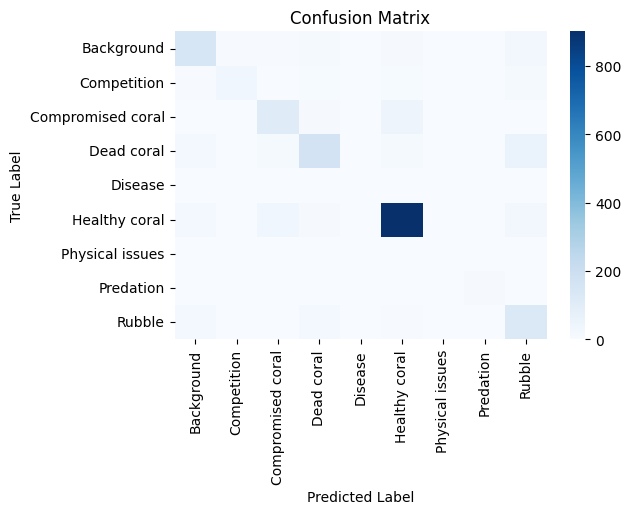

In [ ]:
#SKIP RUNNING THIS
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

resnet18.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = resnet18(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Decode labels
pred_class_names = le.inverse_transform(all_preds)
true_class_names = le.inverse_transform(all_labels)

# Test accuracy
test_acc = accuracy_score(true_class_names, pred_class_names)
print(f"\n Test Accuracy: {test_acc * 100:.2f}%\n")

# Classification report (precision, recall, f1-score)
print(" Classification Report:\n")
print(classification_report(true_class_names, pred_class_names))

#  Confusion Matrix
cm = confusion_matrix(true_class_names, pred_class_names, labels=le.classes_)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=False, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [46]:
#SKIP RUNNING THIS
import timm
import torch

# Set number of classes (same as before)
num_classes = df['label_encoded'].nunique()

# Recreate the model
resnet18 = timm.create_model('resnet18', pretrained=False, num_classes=num_classes)
resnet18.load_state_dict(torch.load('/content/drive/MyDrive/Project/resnet18_coral.pth'))  # Load weights
resnet18.to(device)  # Move to GPU if available
resnet18.eval()  # Set to evaluation mode


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act1): ReLU(inplace=True)
      (aa): Identity()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, m

In [47]:
#SKIP RUNNING THIS
import matplotlib.pyplot as plt
from PIL import Image

def predict_and_show(image_path, model, label_encoder, transform):
    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0).to(device)

    # Run inference
    model.eval()
    with torch.no_grad():
        outputs = model(input_tensor)
        _, pred = torch.max(outputs, 1)

    predicted_label = label_encoder.inverse_transform(pred.cpu().numpy())[0]

    # Show image with prediction
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Predicted: {predicted_label}", fontsize=14)
    plt.show()

    return predicted_label


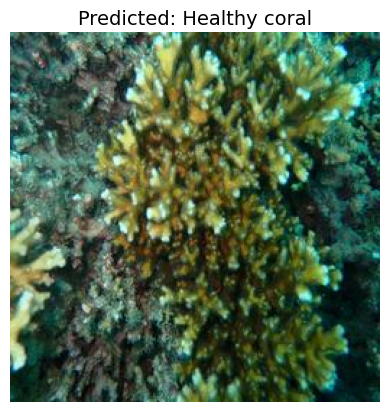

'Healthy coral'

In [ ]:
#SKIP RUNNING THIS
img_path = "/content/drive/MyDrive/Project/resized_images_256/coral_images_dry/20230421_preliminary_survey/20230412_0004.jpg"
predict_and_show(img_path, resnet18, le, transform)


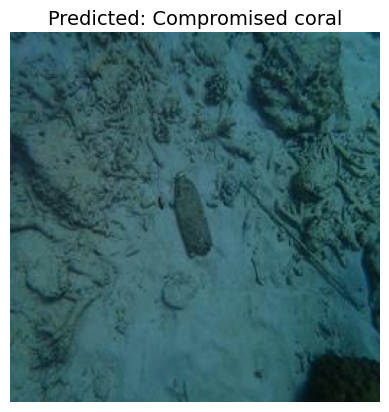

'Compromised coral'

In [ ]:
#SKIP RUNNING THIS
img_path = "/content/drive/MyDrive/Project/resized_images_256/coral_images_wet/D-Data Winter 2024/20240115_TCB_done/TCB_0034_00_20240115_0001.jpg"
predict_and_show(img_path, resnet18, le, transform)

# Training with EfficientNetV2-B2

In [12]:
import timm
print([m for m in timm.list_models() if 'efficientnetv2' in m])



['efficientnetv2_l', 'efficientnetv2_m', 'efficientnetv2_rw_m', 'efficientnetv2_rw_s', 'efficientnetv2_rw_t', 'efficientnetv2_s', 'efficientnetv2_xl', 'gc_efficientnetv2_rw_t', 'tf_efficientnetv2_b0', 'tf_efficientnetv2_b1', 'tf_efficientnetv2_b2', 'tf_efficientnetv2_b3', 'tf_efficientnetv2_l', 'tf_efficientnetv2_m', 'tf_efficientnetv2_s', 'tf_efficientnetv2_xl']


In [13]:
import timm
import torch.nn as nn
import torch

# Load model
num_classes = df['label_encoded'].nunique()
model = timm.create_model('tf_efficientnetv2_b2', pretrained=True, num_classes=num_classes)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/40.8M [00:00<?, ?B/s]

In [14]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=3e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)


In [15]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    model.to(device)  # Make sure model is on the correct device

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        total = 0
        correct = 0

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
            running_loss += loss.item()

        train_acc = 100 * correct / total
        print(f"[Epoch {epoch+1}] Train Loss: {running_loss/len(train_loader):.4f} | Accuracy: {train_acc:.2f}%")

        # Validation
        model.eval()
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, preds = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (preds == labels).sum().item()

        val_acc = 100 * val_correct / val_total
        print(f"Validation Accuracy: {val_acc:.2f}%\n")

        scheduler.step()

    return model


In [ ]:
model = train_model(model, criterion, optimizer, scheduler, num_epochs=10)


[Epoch 1] Train Loss: 1.0087 | Accuracy: 65.79%
Validation Accuracy: 77.16%

[Epoch 2] Train Loss: 0.3752 | Accuracy: 87.19%
Validation Accuracy: 76.65%

[Epoch 3] Train Loss: 0.1621 | Accuracy: 94.50%
Validation Accuracy: 78.45%

[Epoch 4] Train Loss: 0.1002 | Accuracy: 96.63%
Validation Accuracy: 80.39%

[Epoch 5] Train Loss: 0.0866 | Accuracy: 97.24%
Validation Accuracy: 79.23%

[Epoch 6] Train Loss: 0.0385 | Accuracy: 98.97%
Validation Accuracy: 80.39%

[Epoch 7] Train Loss: 0.0158 | Accuracy: 99.55%
Validation Accuracy: 82.32%

[Epoch 8] Train Loss: 0.0122 | Accuracy: 99.73%
Validation Accuracy: 81.42%

[Epoch 9] Train Loss: 0.0108 | Accuracy: 99.76%
Validation Accuracy: 82.19%

[Epoch 10] Train Loss: 0.0084 | Accuracy: 99.84%
Validation Accuracy: 81.42%



In [ ]:
torch.save(model.state_dict(), 'efficientnetv2_b2_coral.pth')


In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch


 Test Accuracy: 80.68%

 Classification Report:

                   precision    recall  f1-score   support

       Background       0.67      0.69      0.68       219
      Competition       0.73      0.49      0.59        75
Compromised coral       0.77      0.64      0.70       172
       Dead coral       0.67      0.76      0.71       284
    Healthy coral       0.90      0.94      0.92       991
  Physical issues       0.00      0.00      0.00         3
        Predation       0.83      0.71      0.77        14
           Rubble       0.72      0.62      0.66       178

         accuracy                           0.81      1936
        macro avg       0.66      0.61      0.63      1936
     weighted avg       0.80      0.81      0.80      1936



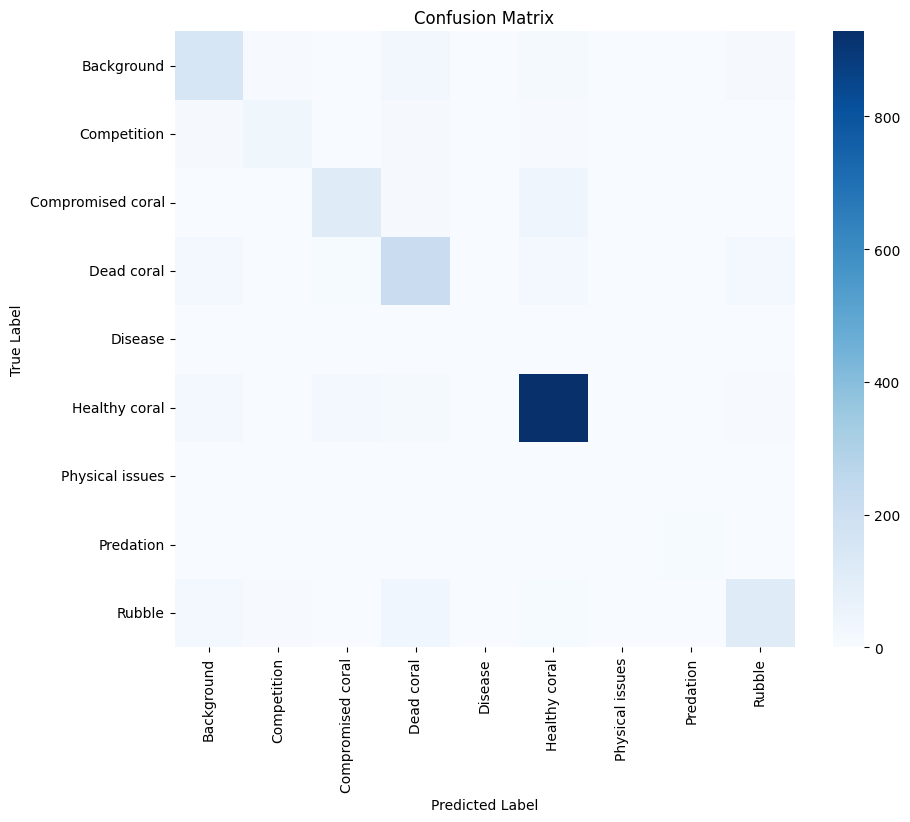

In [ ]:
# Set model to eval mode
model.eval()
all_preds = []
all_labels = []

# Run inference
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Decode to class names
pred_class_names = le.inverse_transform(all_preds)
true_class_names = le.inverse_transform(all_labels)

# Accuracy
test_acc = accuracy_score(true_class_names, pred_class_names)
print(f"\n Test Accuracy: {test_acc * 100:.2f}%\n")

# Classification Report
print(" Classification Report:\n")
print(classification_report(true_class_names, pred_class_names))

# Confusion Matrix
cm = confusion_matrix(true_class_names, pred_class_names, labels=le.classes_)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=False, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [18]:
torch.save(model.state_dict(), '/content/drive/MyDrive/Project/efficientnetv2_b2_coral.pth')

In [19]:
import timm
import torch

# Set number of classes
num_classes = df['label_encoded'].nunique()

# Load EfficientNetV2-B2 without weighted loss
effnet_model = timm.create_model('tf_efficientnetv2_b2', pretrained=False, num_classes=num_classes)
effnet_model.load_state_dict(torch.load('/content/drive/MyDrive/Project/efficientnetv2_b2_coral.pth'))
effnet_model.to(device)
effnet_model.eval()

EfficientNet(
  (conv_stem): Conv2dSame(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNormAct2d(
    32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): ConvBnAct(
        (conv): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNormAct2d(
          16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (aa): Identity()
        (drop_path): Identity()
      )
      (1): ConvBnAct(
        (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNormAct2d(
          16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (aa): Identity()
        (drop_path):

In [20]:
import matplotlib.pyplot as plt
from PIL import Image

def predict_and_show(image_path, model, label_encoder, transform):
    # Load and preprocess
    image = Image.open(image_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0).to(device)

    # Inference
    model.eval()
    with torch.no_grad():
        outputs = model(input_tensor)
        _, pred = torch.max(outputs, 1)

    predicted_label = label_encoder.inverse_transform(pred.cpu().numpy())[0]

    # Show
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Predicted: {predicted_label}", fontsize=14)
    plt.show()

    return predicted_label

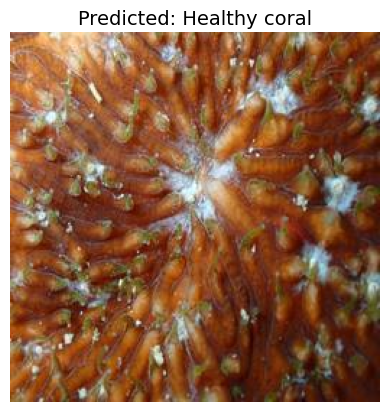

'Healthy coral'

In [21]:
img_path = "/content/drive/MyDrive/Project/resized_images_256/coral_images_wet/D-Data Winter 2024/20240103_SKI_done/SKI_0033_00_20240103_0006.jpg"
predict_and_show(img_path, effnet_model, le, transform)

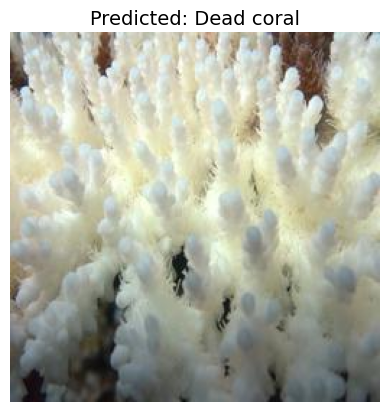

'Dead coral'

In [48]:
img_path = "/content/drive/MyDrive/Project/resized_images_256/coral_images_wet/D-Data Winter 2024/20240119_SKI_done/SKI_0036_00_20240119_0011.jpg"
predict_and_show(img_path, effnet_model, le, transform)

# Training with EfficientNetV2-B2, added Weighted Loss

In [23]:
# Load fresh model
model = timm.create_model('tf_efficientnetv2_b2', pretrained=True, num_classes=num_classes)
model = model.to(device)


In [24]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(df['label_encoded']),
    y=df['label_encoded']
)
weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Define weighted CrossEntropyLoss
criterion = nn.CrossEntropyLoss(weight=weights)


In [25]:
import torch.optim as optim

optimizer = optim.AdamW(model.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)


In [26]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            running_loss += loss.item()

        train_acc = 100 * correct / total
        print(f"[Epoch {epoch+1}] Train Loss: {running_loss/len(train_loader):.4f} | Accuracy: {train_acc:.2f}%")

        # Validation
        model.eval()
        val_correct, val_total = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_acc = 100 * val_correct / val_total
        print(f"Validation Accuracy: {val_acc:.2f}%\n")

        scheduler.step()

    return model


In [ ]:
model = train_model(model, criterion, optimizer, scheduler, num_epochs=10)


[Epoch 1] Train Loss: 1.6487 | Accuracy: 48.01%
Validation Accuracy: 55.35%

[Epoch 2] Train Loss: 0.6843 | Accuracy: 72.84%
Validation Accuracy: 70.45%

[Epoch 3] Train Loss: 0.2700 | Accuracy: 87.93%
Validation Accuracy: 73.55%

[Epoch 4] Train Loss: 0.1348 | Accuracy: 94.36%
Validation Accuracy: 74.45%

[Epoch 5] Train Loss: 0.0842 | Accuracy: 96.37%
Validation Accuracy: 77.68%

[Epoch 6] Train Loss: 0.0411 | Accuracy: 98.56%
Validation Accuracy: 78.19%

[Epoch 7] Train Loss: 0.0221 | Accuracy: 99.37%
Validation Accuracy: 78.32%

[Epoch 8] Train Loss: 0.0199 | Accuracy: 99.48%
Validation Accuracy: 78.84%

[Epoch 9] Train Loss: 0.0160 | Accuracy: 99.55%
Validation Accuracy: 78.97%

[Epoch 10] Train Loss: 0.0211 | Accuracy: 99.10%
Validation Accuracy: 79.61%



In [ ]:
torch.save(model.state_dict(), 'efficientnetv2_b2_unweighted.pth')



 Test Accuracy: 79.49%

 Classification Report:

                   precision    recall  f1-score   support

       Background       0.67      0.70      0.69       219
      Competition       0.65      0.67      0.66        75
Compromised coral       0.70      0.64      0.67       172
       Dead coral       0.69      0.67      0.68       284
    Healthy coral       0.90      0.92      0.91       991
  Physical issues       0.00      0.00      0.00         3
        Predation       0.71      0.86      0.77        14
           Rubble       0.66      0.65      0.65       178

         accuracy                           0.79      1936
        macro avg       0.62      0.64      0.63      1936
     weighted avg       0.79      0.79      0.79      1936



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


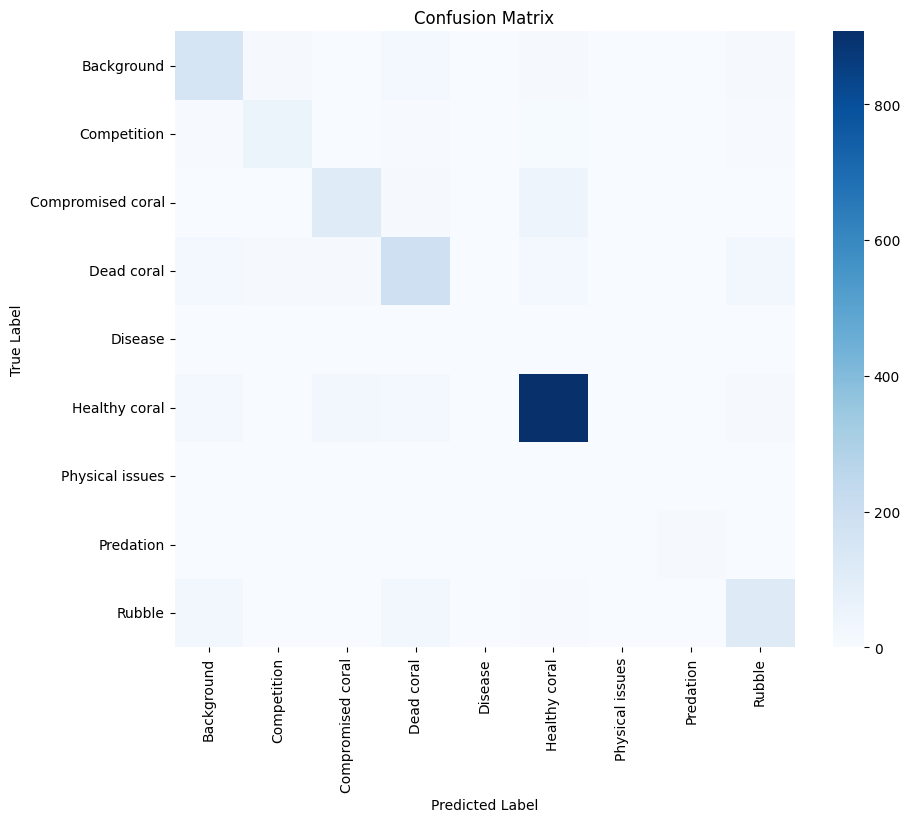

In [ ]:
# Set model to eval mode
model.eval()
all_preds = []
all_labels = []

# Run inference
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Decode to class names
pred_class_names = le.inverse_transform(all_preds)
true_class_names = le.inverse_transform(all_labels)

# Accuracy
test_acc = accuracy_score(true_class_names, pred_class_names)
print(f"\n Test Accuracy: {test_acc * 100:.2f}%\n")

# Classification Report
print(" Classification Report:\n")
print(classification_report(true_class_names, pred_class_names))

# Confusion Matrix
cm = confusion_matrix(true_class_names, pred_class_names, labels=le.classes_)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=False, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [27]:
torch.save(model.state_dict(), '/content/drive/MyDrive/Project/efficientnetv2_b2_unweighted.pth')

In [28]:
import timm
import torch

num_classes = df['label_encoded'].nunique()

effnet_weighted = timm.create_model('tf_efficientnetv2_b2', pretrained=False, num_classes=num_classes)
effnet_weighted.load_state_dict(torch.load('/content/drive/MyDrive/Project/efficientnetv2_b2_unweighted.pth'))
effnet_weighted.to(device)
effnet_weighted.eval()

EfficientNet(
  (conv_stem): Conv2dSame(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNormAct2d(
    32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): ConvBnAct(
        (conv): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNormAct2d(
          16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (aa): Identity()
        (drop_path): Identity()
      )
      (1): ConvBnAct(
        (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNormAct2d(
          16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (aa): Identity()
        (drop_path):

In [29]:
# Prediction function (same structure as before)
import matplotlib.pyplot as plt
from PIL import Image

def predict_and_show(image_path, model, label_encoder, transform):
    image = Image.open(image_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        outputs = model(input_tensor)
        _, pred = torch.max(outputs, 1)

    predicted_label = label_encoder.inverse_transform(pred.cpu().numpy())[0]

    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Predicted: {predicted_label}", fontsize=14)
    plt.show()

    return predicted_label


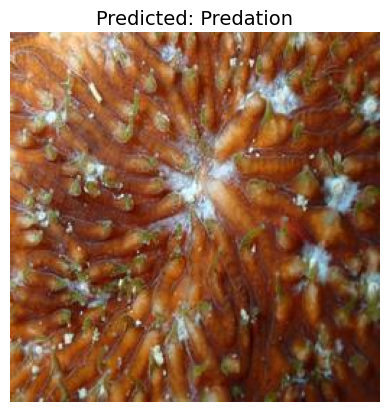

'Predation'

In [32]:
# Test with a different image
img_path = "/content/drive/MyDrive/Project/resized_images_256/coral_images_wet/D-Data Winter 2024/20240103_SKI_done/SKI_0033_00_20240103_0006.jpg"
predict_and_show(img_path, effnet_weighted, le, transform)


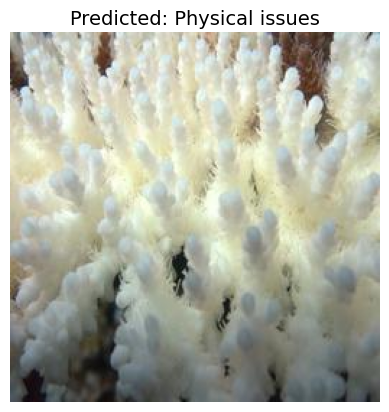

'Physical issues'

In [49]:
img_path = "/content/drive/MyDrive/Project/resized_images_256/coral_images_wet/D-Data Winter 2024/20240119_SKI_done/SKI_0036_00_20240119_0011.jpg"
predict_and_show(img_path, effnet_weighted, le, transform)

# Training with TResNet

In [34]:
import timm

# Count classes
num_classes = df['label_encoded'].nunique()

# Create TResNet with pretrained weights
model = timm.create_model('tresnet_m', pretrained=True, num_classes=num_classes)
model = model.to(device)


model.safetensors:   0%|          | 0.00/126M [00:00<?, ?B/s]

In [35]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import torch.nn as nn

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(df['label_encoded']),
    y=df['label_encoded']
)

weights = torch.tensor(class_weights, dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=weights)


In [36]:
import torch.optim as optim

optimizer = optim.AdamW(model.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)


In [37]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    train_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = 100 * correct / total
        train_losses.append(epoch_loss)

        # Validation
        model.eval()
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_acc = 100 * correct_val / total_val
        val_accuracies.append(val_acc)

        print(f"[Epoch {epoch+1}] Train Loss: {epoch_loss:.4f} | Accuracy: {epoch_acc:.2f}%")
        print(f"Validation Accuracy: {val_acc:.2f}%\n")

        scheduler.step()

    return model, train_losses, val_accuracies


In [ ]:
model, train_losses, val_accuracies = train_model(model, criterion, optimizer, scheduler, num_epochs=10)

[Epoch 1] Train Loss: 1.5776 | Accuracy: 52.94%
Validation Accuracy: 63.87%

[Epoch 2] Train Loss: 1.0775 | Accuracy: 65.44%
Validation Accuracy: 71.23%

[Epoch 3] Train Loss: 0.8074 | Accuracy: 70.52%
Validation Accuracy: 62.32%

[Epoch 4] Train Loss: 0.6452 | Accuracy: 75.16%
Validation Accuracy: 67.23%

[Epoch 5] Train Loss: 0.4304 | Accuracy: 81.79%
Validation Accuracy: 75.87%

[Epoch 6] Train Loss: 0.2434 | Accuracy: 89.46%
Validation Accuracy: 79.35%

[Epoch 7] Train Loss: 0.1195 | Accuracy: 94.52%
Validation Accuracy: 81.81%

[Epoch 8] Train Loss: 0.0847 | Accuracy: 96.27%
Validation Accuracy: 79.74%

[Epoch 9] Train Loss: 0.0638 | Accuracy: 97.11%
Validation Accuracy: 82.71%

[Epoch 10] Train Loss: 0.0563 | Accuracy: 97.73%
Validation Accuracy: 80.26%




 Test Accuracy: 75.52%

 Classification Report:

                   precision    recall  f1-score   support

       Background       0.58      0.73      0.65       219
      Competition       0.54      0.49      0.52        75
Compromised coral       0.61      0.69      0.64       172
       Dead coral       0.74      0.48      0.59       284
          Disease       0.00      0.00      0.00         0
    Healthy coral       0.90      0.88      0.89       991
  Physical issues       0.00      0.00      0.00         3
        Predation       0.81      0.93      0.87        14
           Rubble       0.55      0.72      0.63       178

         accuracy                           0.76      1936
        macro avg       0.53      0.55      0.53      1936
     weighted avg       0.77      0.76      0.76      1936



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


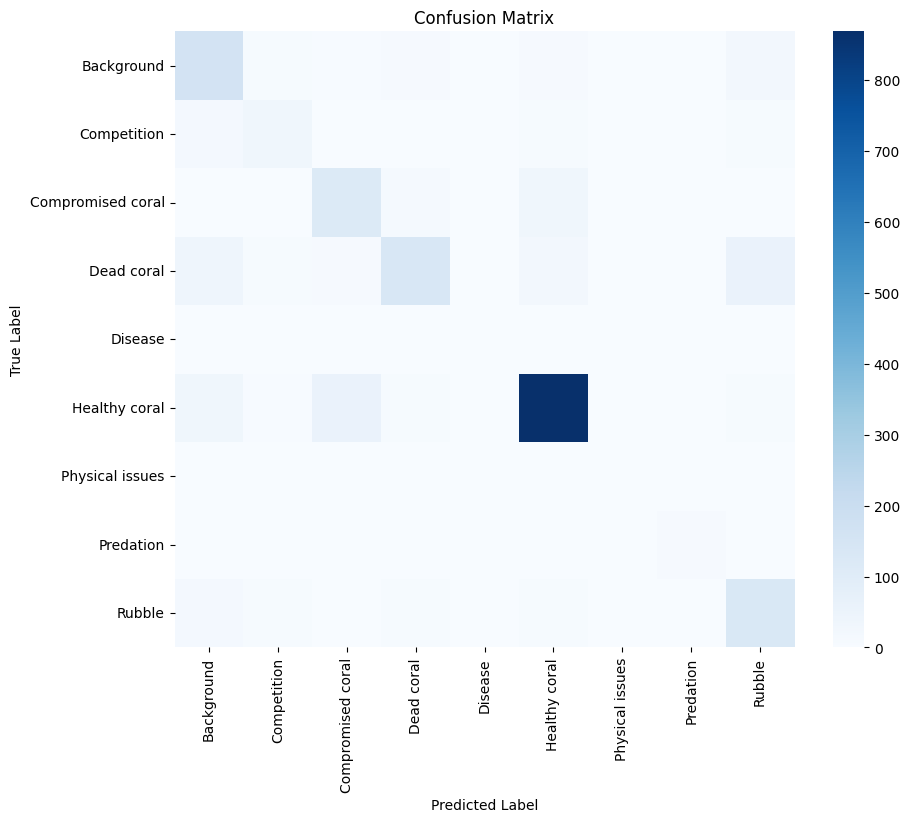

In [ ]:
# Set model to eval mode
model.eval()
all_preds = []
all_labels = []

# Run inference
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Decode to class names
pred_class_names = le.inverse_transform(all_preds)
true_class_names = le.inverse_transform(all_labels)

# Accuracy
test_acc = accuracy_score(true_class_names, pred_class_names)
print(f"\n Test Accuracy: {test_acc * 100:.2f}%\n")

# Classification Report
print(" Classification Report:\n")
print(classification_report(true_class_names, pred_class_names))

# Confusion Matrix
cm = confusion_matrix(true_class_names, pred_class_names, labels=le.classes_)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=False, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [ ]:
torch.save(model.state_dict(), 'tresnet.pth')

In [39]:
torch.save(model.state_dict(), '/content/drive/MyDrive/Project/tresnet.pth')

In [56]:
# Load TResNet
tresnet_model = timm.create_model('tresnet_m', pretrained=False, num_classes=num_classes)
tresnet_model.load_state_dict(torch.load('/content/drive/MyDrive/Project/tresnet.pth'))
tresnet_model.to(device)
tresnet_model.eval()


TResNet(
  (body): Sequential(
    (s2d): SpaceToDepth()
    (conv1): ConvNormAct(
      (conv): Conv2d(48, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNormAct2d(
        64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): LeakyReLU(negative_slope=0.01, inplace=True)
      )
    )
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): ConvNormAct(
          (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn): BatchNormAct2d(
            64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): LeakyReLU(negative_slope=0.001, inplace=True)
          )
        )
        (conv2): ConvNormAct(
          (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn): BatchNormAct2d(
            64, eps=1e-05, momentum=0.1, affine=True, track

In [41]:
import matplotlib.pyplot as plt
from PIL import Image

def predict_and_show(image_path, model, label_encoder, transform):
    # Load and preprocess
    image = Image.open(image_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0).to(device)

    # Inference
    model.eval()
    with torch.no_grad():
        outputs = model(input_tensor)
        _, pred = torch.max(outputs, 1)

    predicted_label = label_encoder.inverse_transform(pred.cpu().numpy())[0]

    # Show
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Predicted: {predicted_label}", fontsize=14)
    plt.show()

    return predicted_label

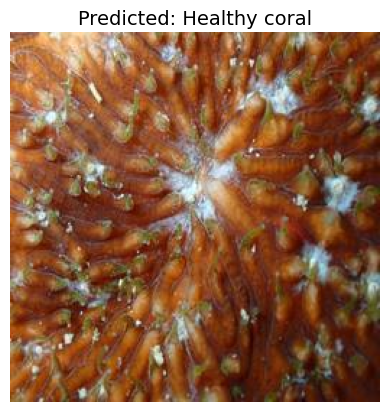

'Healthy coral'

In [50]:
img_path = "/content/drive/MyDrive/Project/resized_images_256/coral_images_wet/D-Data Winter 2024/20240103_SKI_done/SKI_0033_00_20240103_0006.jpg"
predict_and_show(img_path, tresnet_model, le, transform)

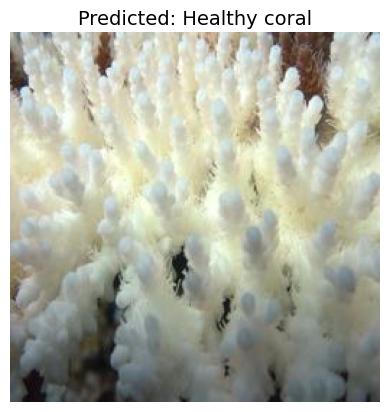

'Healthy coral'

In [51]:
img_path = "/content/drive/MyDrive/Project/resized_images_256/coral_images_wet/D-Data Winter 2024/20240119_SKI_done/SKI_0036_00_20240119_0011.jpg"
predict_and_show(img_path, tresnet_model, le, transform)